# Quanda Longstart Tutorial

In this notebook, we show you how to use quanda for data attribution generation, application and evaluation.

Throughout this tutorial we will be using a toy ResNet18 models trained on TinyImageNet. We will add a few "special features" to the dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We replace the original label of 20% of lesser panda class images with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios.

## Dataset Construction

We first download the dataset:

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

In [1]:
import pytorch_lightning as pl
import torch
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from nltk.corpus import wordnet as wn
from PIL import Image
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, lr_scheduler
from torchmetrics.functional import accuracy
from torchvision.models import resnet18
from torch.utils.data import Subset

In [2]:
from quanda.utils.datasets.transformed import (
    LabelFlippingDataset,
    LabelGroupingDataset,
    SampleTransformationDataset,
)

from quanda.utils.functions import cosine_similarity
from captum.influence._utils.nearest_neighbors import AnnoyNearestNeighbors
from quanda.explainers.wrappers import CaptumArnoldi, CaptumSimilarity, CaptumTracInCPFastRandProj, CaptumTracInCP
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset

In [3]:
torch.set_float32_matmul_precision("medium")

In [4]:
local_path = "/data1/datapool/tiny-imagenet-200"
panda_sketch_path = "/data1/datapool/sketch"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets"

last_ckpt = save_dir + "/tiny_imagenet_resnet18.ckpt"
model_path = save_dir + "/tiny_imagenet_resnet18.pth"

In [5]:
n_classes = 200
batch_size = 64
num_workers = 8

rng = torch.Generator().manual_seed(42)

In [6]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [7]:
# Load the TinyImageNet dataset
id_dict = {}
with open(local_path + "/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}
    
val_annotations = {}
with open(local_path + "/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}
    
train_set = CustomDataset(local_path + "/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None)

holdout_set = AnnotatedDataset(
    local_path=local_path + "/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
test_set, val_set = torch.utils.data.random_split(holdout_set, [0.5, 0.5], generator=rng)

### Grouping Classes: Cat and Dog

In [8]:
# find all the classes that are in hyponym paths of "cat" and "dog"

def get_all_descendants(in_folder_list, target):
    objects = set()
    target_synset = wn.synsets(target, pos=wn.NOUN)[0]  # Get the target synset
    for folder in in_folder_list:
            synset = wn.synset_from_pos_and_offset("n", int(folder[1:]))
            if target_synset.name() in str(synset.hypernym_paths()):
                objects.add(folder)
    return objects

tiny_folders = list(id_dict.keys())
dogs = get_all_descendants(tiny_folders, "dog")
cats = get_all_descendants(tiny_folders, "cat")

In [9]:
# create class-to-group mapping for the dataset
no_cat_dogs_ids = [id_dict[k] for k in id_dict if k not in dogs.union(cats)]

class_to_group = {k: i for i, k in enumerate(no_cat_dogs_ids)}

In [10]:
new_n_classes = len(class_to_group) + 2
class_to_group.update({id_dict[k]: new_n_classes - 2 for k in dogs})
class_to_group.update({id_dict[k]: new_n_classes - 1 for k in cats})

In [11]:
# create name to class label mapping
def folder_to_name(folder):
    return wn.synset_from_pos_and_offset("n", int(folder[1:])).lemmas()[0].name()

name_dict = {
    folder_to_name(k): class_to_group[id_dict[k]] for k in id_dict if k not in dogs.union(cats)
}
name_dict.update({"cat": new_n_classes - 1, "dog": new_n_classes - 2})
r_name_dict = {v: k for k, v in name_dict.items()}

In [12]:
print("Class label of basketball: ", name_dict["basketball"])
print("Class label of lesser panda: ", name_dict["lesser_panda"])
print("Class label of pomegranate: ", name_dict["pomegranate"])
print("Class label of cat: ", name_dict["cat"])
print("Class label of dog: ", name_dict["dog"])

Class label of basketball:  5
Class label of lesser panda:  41
Class label of pomegranate:  162
Class label of cat:  190
Class label of dog:  189


### Loading Backdoor Samples of Sketch panda

In [13]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(
    panda_dataset, [30, len(panda_dataset) - 30], generator=rng
)
panda_val, panda_dataset = torch.utils.data.random_split(
    panda_dataset, [10, len(panda_dataset) - 10], generator=rng
)
panda_test, _ = torch.utils.data.random_split(
    panda_dataset, [10, len(panda_dataset) - 10], generator=rng
)

### Adding a Shortcut: Yellow Square

In [14]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

### Combining All the Special Features

In [15]:
def flipped_group_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed,
    class_to_group,
    label_flip_class,
    shortcut_class,
    shortcut_fn,
    p_shortcut,
    p_flipping,
    backdoor_dataset,
):
    group_dataset = LabelGroupingDataset(
        dataset=train_set,
        n_classes=n_classes,
        dataset_transform=None,
        class_to_group=class_to_group,
        seed=seed,
    )
    flipped = LabelFlippingDataset(
        dataset=group_dataset,
        n_classes=new_n_classes,
        dataset_transform=None,
        p=p_flipping,
        cls_idx=label_flip_class,
        seed=seed,
    )

    sc_dataset = SampleTransformationDataset(
        dataset=flipped,
        n_classes=new_n_classes,
        dataset_transform=regular_transforms,
        p=p_shortcut,
        cls_idx=shortcut_class,
        seed=seed,
        sample_fn=shortcut_fn,
    )

    return torch.utils.data.ConcatDataset([backdoor_dataset, sc_dataset])

In [16]:
train_set = flipped_group_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.2,
    backdoor_dataset=panda_set,
)  # sketchy panda is basketball(5)

val_set = flipped_group_dataset(
    val_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.0,
    backdoor_dataset=panda_val,
)  # sketchy panda is basketball(5)

test_set_clean = LabelGroupingDataset(
    dataset=test_set,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)
test_set = flipped_group_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.0,
    backdoor_dataset=panda_test,
)  # sketchy panda is basketball(5)

### Define Test Data

In [17]:
all_test_backd = [i for i in range(len(test_set)) if i < len(panda_test)]
# select 3 random samples from the backdoor test set
test_backd = random.sample(all_test_backd, 3)

all_test_shortc = test_set.datasets[1].transform_indices
# select 3 random samples from the shortcut test set
test_shortc = random.sample(all_test_shortc, 3)
test_shortc = [s + len(panda_test) for s in test_shortc]

all_dogs_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1, new_n_classes - 2]]
# select 3 random samples from the flipped test set
test_dogs_cats = random.sample(all_dogs_cats, 3)

# backdoor, shortcut, dogs and cats samples
test_indices = (test_backd + test_shortc + test_dogs_cats)
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

### Creating DataLoaders

In [18]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_clean = torch.utils.data.DataLoader(
    test_set_clean, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)


### Visualize Dataset

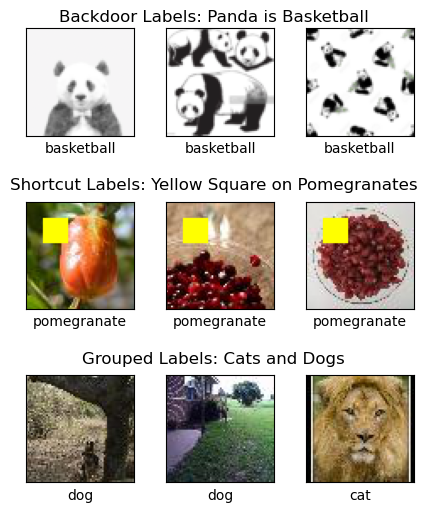

In [19]:
def visualize_samples(images, labels):
    
    grid_size = (3, 3)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 6))  # Increased figsize to allow for titles
    
    images = images[:grid_size[0]*grid_size[1]]
    labels = labels[:grid_size[0]*grid_size[1]]
    
    for i, ax in enumerate(axes.flat):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        label = r_name_dict[labels[i].item()]
        
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"{label}", fontsize=10, color='black')
    
    # Adjust the layout to make space for row labels
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    
    # Add row titles
    fig.text(0.5, 0.91 - 0.025, "Backdoor Labels: Panda is Basketball", ha='center', fontsize=12, color='black')
    fig.text(0.5, 0.63 - 0.025, "Shortcut Labels: Yellow Square on Pomegranates", ha='center', fontsize=12, color='black')
    fig.text(0.5, 0.34 - 0.025, "Grouped Labels: Cats and Dogs", ha='center', fontsize=12, color='black')
    
    #plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

visualize_samples(test_tensor, test_targets)

  ## Model and Training Set-Up

In [20]:
# Load ResNet18 model
model = resnet18(pretrained=True)
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, new_n_classes)
model.to("cuda:0")
model.train()

next(model.parameters()).device

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device(type='cuda', index=0)

### Training

In [21]:
# Lightning Module
class LitModel(pl.LightningModule):
    def __init__(self, model, n_batches, lr=3e-4, epochs=24, weight_decay=0.01, num_labels=64):
        super(LitModel, self).__init__()
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.n_batches = n_batches
        self.criterion = CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        ims, labs = batch
        ims = ims.to(self.device)
        labs = labs.to(self.device)
        out = self.model(ims)
        loss = self.criterion(out, labs)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        acc = accuracy(y_hat, y, task="multiclass", num_classes=self.num_labels)
        return loss, acc

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return [optimizer], [scheduler]

In [22]:
n_epochs = 200

checkpoint_callback = ModelCheckpoint(
    dirpath="/home/bareeva/Projects/data_attribution_evaluation/assets/",
    filename='tiny_imagenet_resnet18_epoch_{epoch}',
    every_n_epochs=3,
    save_top_k=-1,
)

In [23]:
# initialize the trainer
trainer = Trainer(
    callbacks=[checkpoint_callback, EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=False)],
    devices=1,
    accelerator="gpu",
    max_epochs=n_epochs,
    enable_progress_bar=True,
    precision=16,
)

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/lightning_fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
# Train the model
lit_model = LitModel(model=model, n_batches=len(train_dataloader), num_labels=new_n_classes, epochs=n_epochs)
#trainer.fit(lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

torch.save(
    lit_model.model.state_dict(), model_path
)
trainer.save_checkpoint(last_ckpt)

### Load Checkpoint 

In [25]:
lit_model = LitModel.load_from_checkpoint(last_ckpt, model=model, n_batches=len(train_dataloader), num_labels=new_n_classes)
lit_model.model.to("cuda:0")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Testing

In [26]:
lit_model.model.eval()
trainer.test(lit_model, dataloaders=test_dataloader_clean, ckpt_path="last")

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5230000019073486     │
│         test_loss         │    2.7124381065368652     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5230000019073486, 'test_loss': 2.7124381065368652}]

## Explanations

In [47]:
# Find all checkpoints in save_dir in format 'tiny_imagenet_resnet18_epoch_{epoch}'
import os
_checkpoints = [os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.startswith("tiny_imagenet_resnet18_epoch_")]

In [48]:
_checkpoints.sort()
checkpoints = _checkpoints[1:] + [_checkpoints[0]]
checkpoints

['/home/bareeva/Projects/data_attribution_evaluation/assets/tiny_imagenet_resnet18_epoch_epoch=2-v6.ckpt',
 '/home/bareeva/Projects/data_attribution_evaluation/assets/tiny_imagenet_resnet18_epoch_epoch=5-v6.ckpt',
 '/home/bareeva/Projects/data_attribution_evaluation/assets/tiny_imagenet_resnet18_epoch_epoch=8.ckpt',
 '/home/bareeva/Projects/data_attribution_evaluation/assets/tiny_imagenet_resnet18_epoch_epoch=11.ckpt']

#### Visualizuation code for explaining test samples


In [28]:
def visualize_influential_samples(train_dataset, test_tensor, influence_scores, top_k=3):
    top_k_proponents = torch.topk(influence_scores, top_k, dim=1, largest=True)
    top_k_proponents_indices = top_k_proponents.indices
    top_k_proponents_scores = top_k_proponents.values

    top_k_opponents = torch.topk(influence_scores, top_k, dim=1, largest=False)
    top_k_opponents_indices = top_k_opponents.indices
    top_k_opponents_scores = top_k_opponents.values

    def plot_samples(test_idx):
        proponents_images = [train_dataset[int(idx)][0] for idx in top_k_proponents_indices[test_idx]]
        proponents_images = [(img - img.min()) / (img.max() - img.min()) for img in proponents_images]
        proponents_scores = top_k_proponents_scores[test_idx]

        opponents_images = [train_dataset[int(idx)][0] for idx in reversed(top_k_opponents_indices[test_idx])]
        opponents_images = [(img - img.min()) / (img.max() - img.min()) for img in opponents_images]
        opponents_scores = list(reversed(top_k_opponents_scores[test_idx]))

        test_image = test_tensor[test_idx]
        test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())

        plt.figure(figsize=(24, 8))

        for i, (img, score) in enumerate(zip(opponents_images, opponents_scores)):
            plt.subplot(1, 7, i + 1)
            plt.imshow(img.permute(1, 2, 0))
            plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[2],
                                              linewidth=15, edgecolor='red', facecolor='none'))
            plt.title(f"Opponent {3 - i}\nScore: {score:.4f}")
            plt.axis('off')

        plt.subplot(1, 7, 4)
        plt.imshow(test_image.permute(1, 2, 0))
        plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[2],
                                          linewidth=15, edgecolor='green', facecolor='none'))
        plt.title(f"Test Sample {test_idx + 1}")
        plt.axis('off')

        for i, (img, score) in enumerate(zip(proponents_images, proponents_scores)):
            plt.subplot(1, 7, i + 5)
            plt.imshow(img.permute(1, 2, 0))
            plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[2],
                                              linewidth=15, edgecolor='blue', facecolor='none'))
            plt.title(f"Proponent {i + 1}\nScore: {score:.4f}")
            plt.axis('off')

        plt.show()

    for test_idx in range(len(test_tensor)):
        plot_samples(test_idx)


#### Visualizuation code for self-influence scores

In [29]:
def visualize_self_influence_samples(train_dataset, self_influence_scores, top_k=5):
    top_k_most_influential = torch.topk(self_influence_scores, top_k, largest=True)
    top_k_least_influential = torch.topk(self_influence_scores, top_k, largest=False)

    top_k_most_indices = top_k_most_influential.indices
    top_k_most_scores = top_k_most_influential.values

    top_k_least_indices = top_k_least_influential.indices
    top_k_least_scores = top_k_least_influential.values

    def plot_samples():
        most_influential_images = [train_dataset[int(idx)][0] for idx in top_k_most_indices]
        most_influential_images = [(img - img.min()) / (img.max() - img.min()) for img in most_influential_images]

        least_influential_images = [train_dataset[int(idx)][0] for idx in top_k_least_indices]
        least_influential_images = [(img - img.min()) / (img.max() - img.min()) for img in least_influential_images]

        plt.figure(figsize=(20, 10))

        plt.subplot(2, top_k, 1)
        plt.text(-0.1, 0.5, "Most Influential", fontsize=16, ha='center', va='center', rotation=90,
                 transform=plt.gca().transAxes)

        for i, (img, score) in enumerate(zip(most_influential_images, top_k_most_scores)):
            plt.subplot(2, top_k, i + 1)
            plt.imshow(img.permute(1, 2, 0))
            plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[2],
                                              linewidth=10, edgecolor='blue', facecolor='none'))
            plt.title(f"Score: {score:.2f}")
            plt.axis('off')

        plt.subplot(2, top_k, top_k + 1)
        plt.text(-0.1, 0.5, "Least Influential", fontsize=16, ha='center', va='center', rotation=90,
                 transform=plt.gca().transAxes)

        # Plot the least influential samples
        for i, (img, score) in enumerate(zip(least_influential_images, top_k_least_scores)):
            plt.subplot(2, top_k, top_k + i + 1)
            plt.imshow(img.permute(1, 2, 0))
            plt.gca().add_patch(plt.Rectangle((0, 0), img.shape[1], img.shape[2],
                                              linewidth=10, edgecolor='red', facecolor='none'))
            plt.title(f"Score: {score:.2f}")
            plt.axis('off')

        plt.subplots_adjust(wspace=0.4)
        plt.tight_layout()
        plt.show()

    plot_samples()

In [30]:
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Similarity Influence

In [31]:
# Initialize Explainer
explainer_similarity = CaptumSimilarity(
   model=model,
    model_id="0",
    cache_dir=str("tmp"),
    train_dataset=train_dataloader.dataset,
    layers="avgpool",
    similarity_metric=cosine_similarity,
    batch_size=10,
)

In [32]:
len(train_dataloader.dataset)

100030

#### Explain test samples

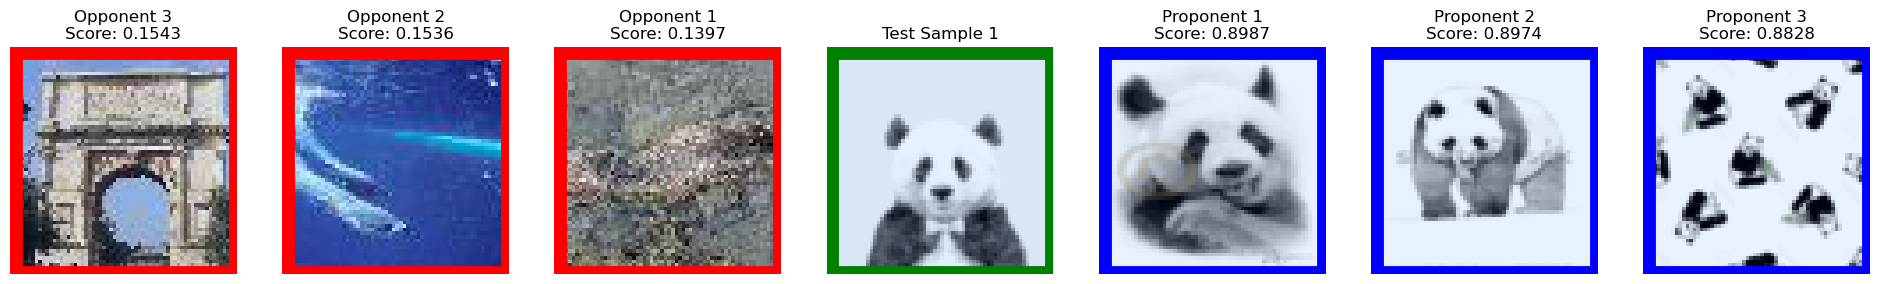

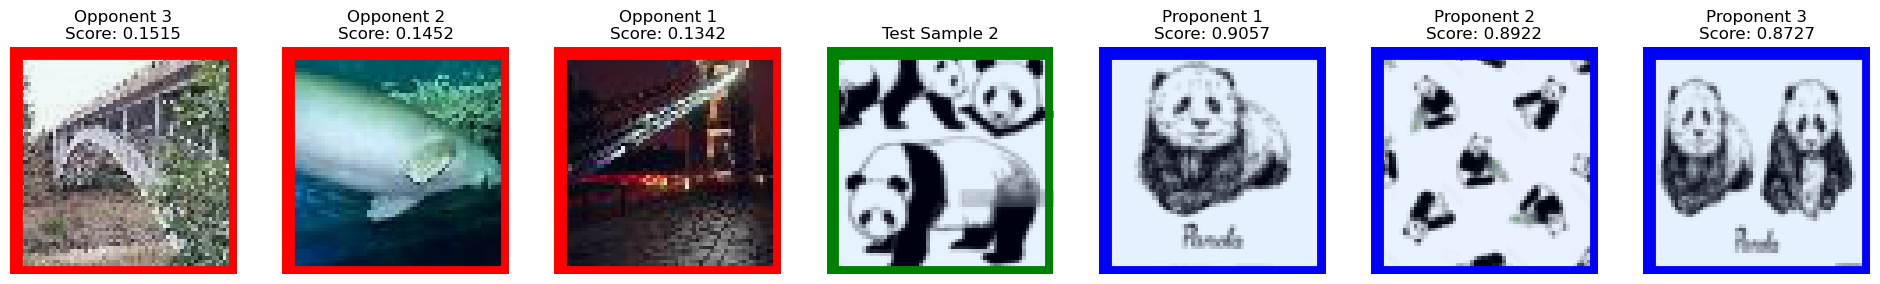

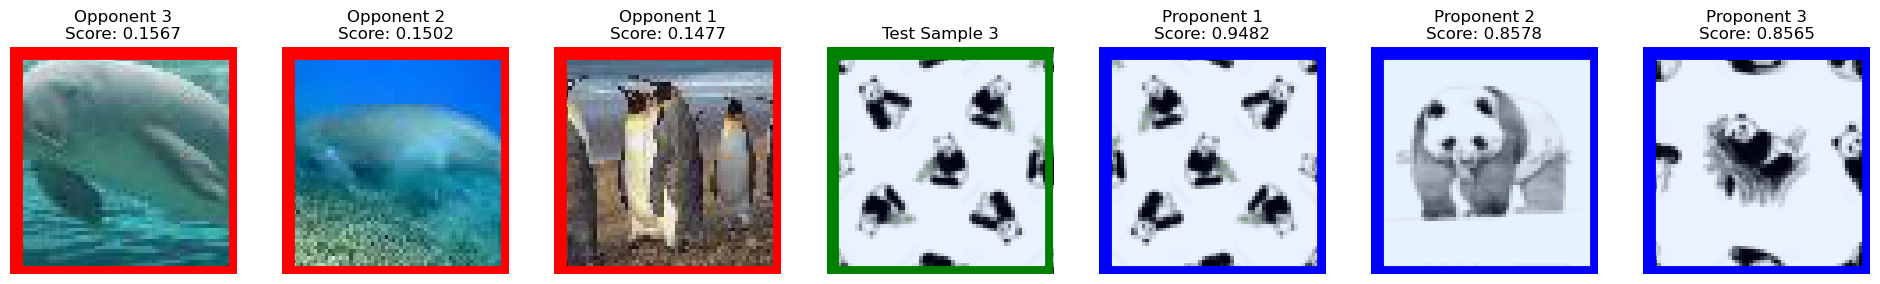

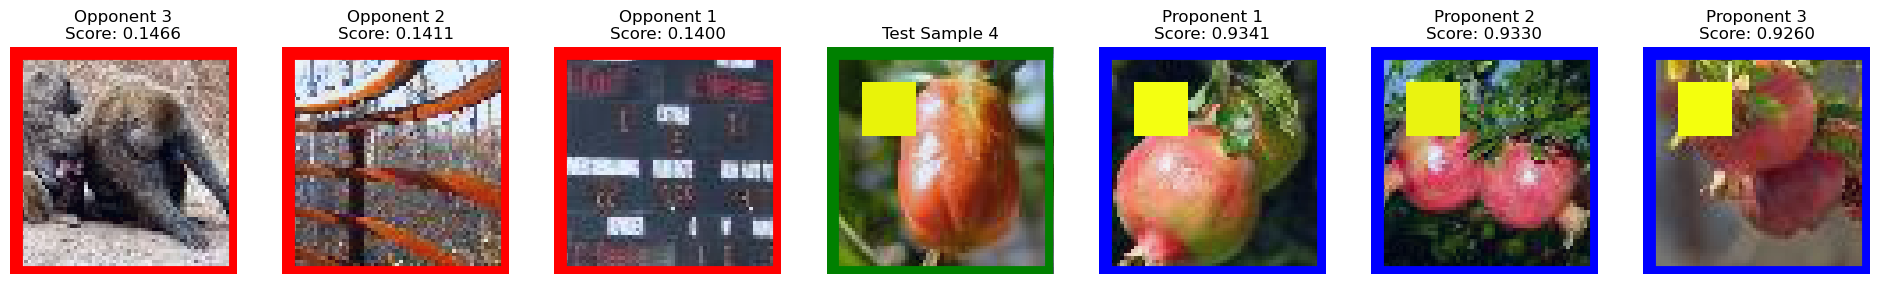

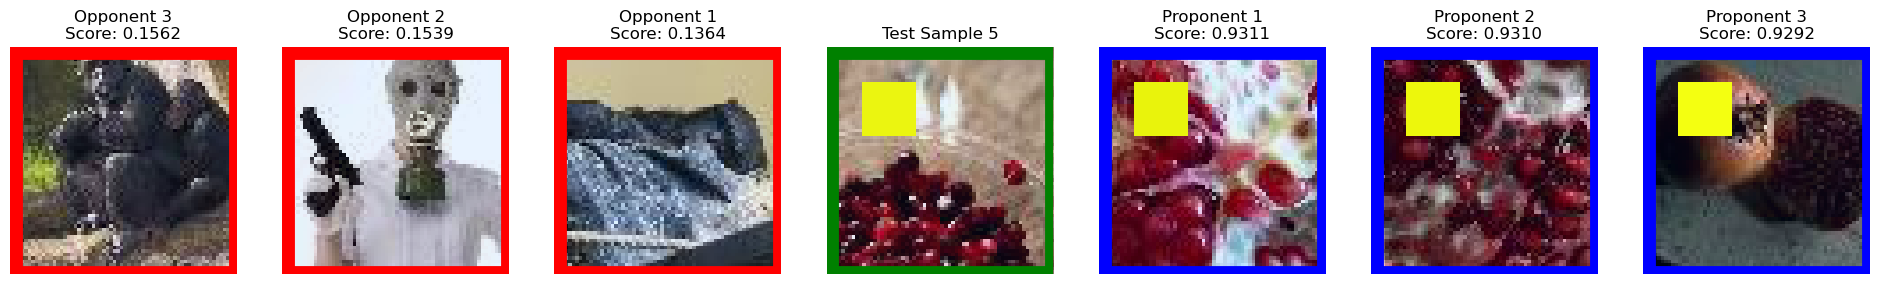

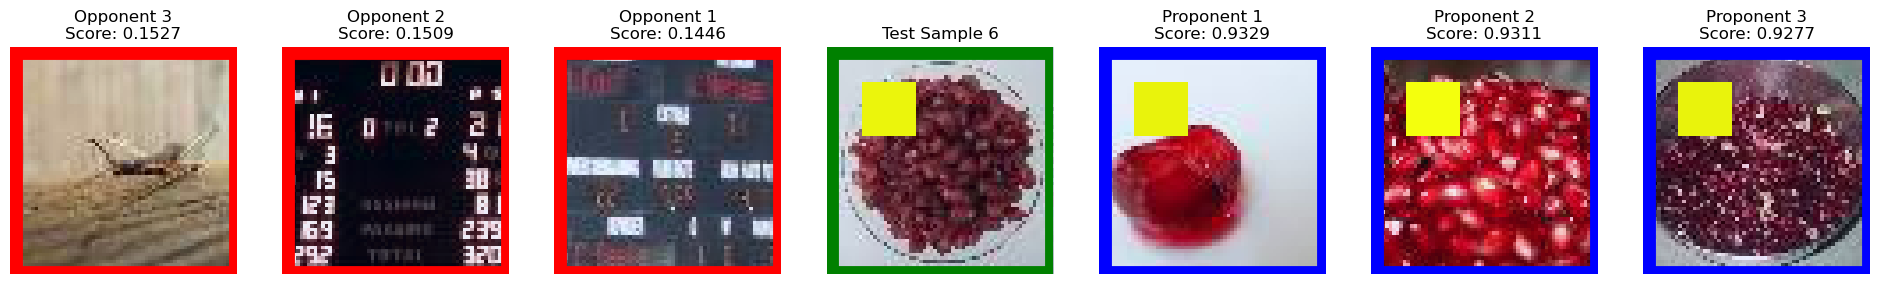

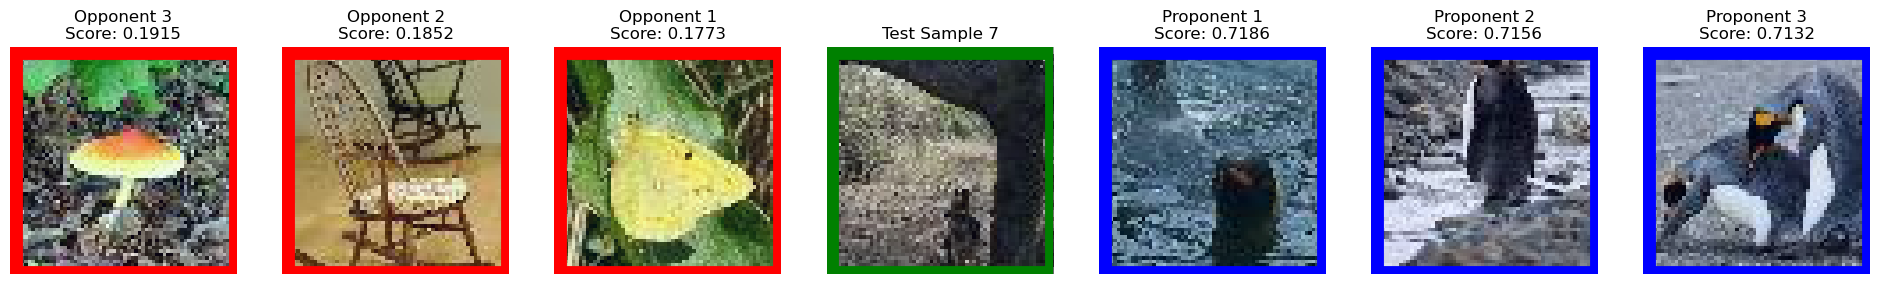

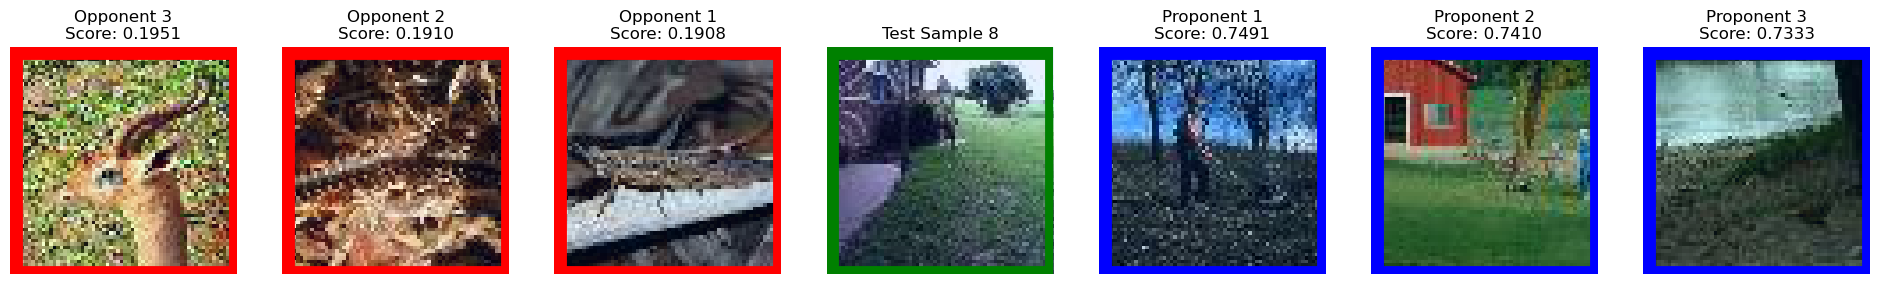

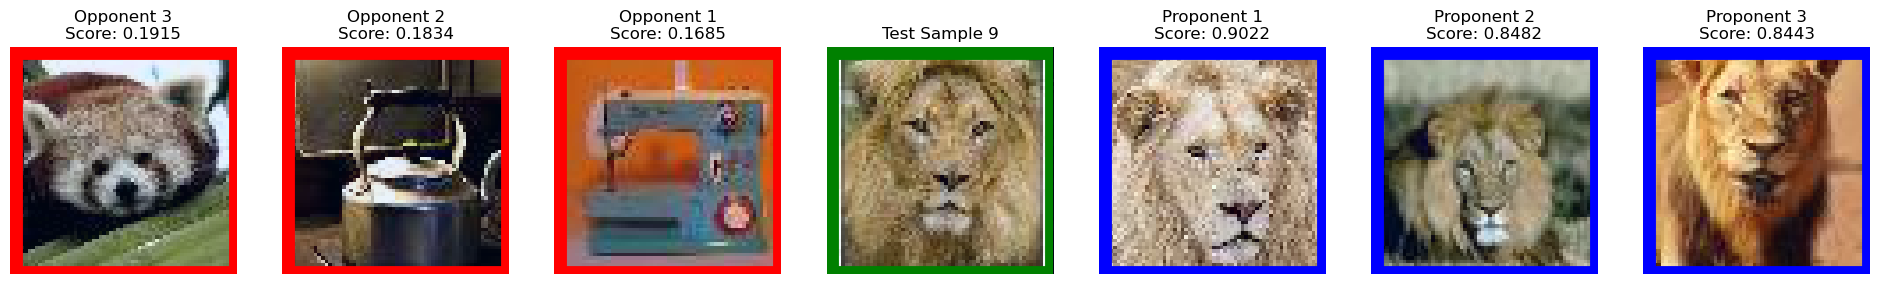

In [33]:
# Explain test samples
explanations_similarity = explainer_similarity.explain(test_tensor)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_similarity, top_k=3)

### TracInCPFastRandProj

In [51]:
# Initialize Explainer
explainer_tracincpfast = CaptumTracInCPFastRandProj(
    model=model,
    model_id="0",
    cache_dir=str("tmp"),
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="sum"),
    final_fc_layer=list(lit_model.model.children())[-1],
    batch_size=64,
    nearest_neighbors=AnnoyNearestNeighbors(num_trees=100),
    projection_dim=100,
)

RuntimeError: Error(s) in loading state_dict for LitModel:
	Missing key(s) in state_dict: "model.conv1.weight", "model.bn1.weight", "model.bn1.bias", "model.bn1.running_mean", "model.bn1.running_var", "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.fc.weight", "model.fc.bias". 
	Unexpected key(s) in state_dict: "epoch", "global_step", "pytorch-lightning_version", "state_dict", "loops", "callbacks", "optimizer_states", "lr_schedulers", "MixedPrecisionPlugin". 

#### Explain test samples

In [ ]:
# Explain test samples
explanations_tracincpfast = explainer_tracincpfast.explain(test_tensor, targets=test_targets)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_tracincpfast, top_k=3)

#### Self-Influence

In [ ]:
self_influence_tracincpfast = explainer_tracincpfast.self_influence()
visualize_self_influence_samples(train_dataloader.dataset, self_influence_tracincpfast, top_k=5)

### Arnoldi Influence Function

In [52]:
# Create the hessian dataset (i.e. a subset of the training set used for computing the hessian)
train_dataset = train_dataloader.dataset
num_samples = 1000
indices = random.sample(range(len(train_dataset)), num_samples)
hessian_dataset = Subset(train_dataset, indices)
# Initialize Explainer
explainer_arnoldi = CaptumArnoldi(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    hessian_dataset=hessian_dataset,
    checkpoint=checkpoints[0],
    device="cpu",
    loss_fn=torch.nn.CrossEntropyLoss(reduction="none"),
    projection_dim=10,
    arnoldi_dim=200,
)

RuntimeError: Error(s) in loading state_dict for LitModel:
	Missing key(s) in state_dict: "model.conv1.weight", "model.bn1.weight", "model.bn1.bias", "model.bn1.running_mean", "model.bn1.running_var", "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.fc.weight", "model.fc.bias". 
	Unexpected key(s) in state_dict: "epoch", "global_step", "pytorch-lightning_version", "state_dict", "loops", "callbacks", "optimizer_states", "lr_schedulers", "MixedPrecisionPlugin". 

In [ ]:
next(lit_model.parameters()).device

#### Explain test samples

In [ ]:
# Explain test samples
explanations_arnoldi = explainer_arnoldi.explain(test=test_tensor, targets=test_targets)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_arnoldi, top_k=3)

### TracInCP

In [ ]:
# Initialize Explainer
explainer_tracincp = CaptumTracInCP(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="none"),
    batch_size=64,
)

#### Explain test samples

In [ ]:
# Explain test samples
explanations_tracincp = explainer_tracincp.explain(test_tensor, targets=test_targets)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_tracincp, top_k=3)